# **Control Inteligente**
# **Control de Posición Difuso**

## **Robot Móvil Diferencial**

<img src="https://www.mdpi.com/mathematics/mathematics-10-03990/article_deploy/html/images/mathematics-10-03990-g001.png" alt="robot_diferencial" width="500"/>

### Modelo Cinemático
$$\large\begin{align*}
\dot{x} &= v\cos(\theta) \\
\dot{y} &= v\sin(\theta) \\
\dot{\theta} &= \omega
\end{align*}$$
$$\large v=\frac{r}{2}(\omega_r+\omega_l) \hspace{10mm} \large\omega=\frac{r}{2}(\omega_r-\omega_l)$$
$$\large\omega_r=\frac{v+\frac{L}{2}\omega}{r} \hspace{10mm} \large\omega_l=\frac{v-\frac{L}{2}\omega}{r}$$

## Librerías

In [ ]:
#pip install scikit-fuzzy networkx

In [ ]:
import sim
import numpy as np
import math
import time
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import skfuzzy as fuzz
from skfuzzy import control as ctrl
t_ini = time.time()
pi = math.pi

## Comunicación con CoppeliaSim

In [ ]:
def connect(port):
    sim.simxFinish(-1)
    clientID=sim.simxStart('127.0.0.1',port,True,True,2000,5)
    if clientID == 0: print("conectado a", port)
    else: print("no se pudo conectar")
    return clientID

In [ ]:
clientID = connect(19999)
_, system = sim.simxGetObjectHandle(clientID,'./PioneerP3DX',sim.simx_opmode_blocking)
_, right_wheel = sim.simxGetObjectHandle(clientID,'./rightMotor',sim.simx_opmode_blocking)
_, left_wheel = sim.simxGetObjectHandle(clientID,'./leftMotor',sim.simx_opmode_blocking)

conectado a 19999


## Control manual (Lazo abierto)

In [ ]:
def manual_control(linear_speed, angular_speed):
    wheel_radius = 0.0975
    distance_wheels = 0.331
    angular_speed_right = (linear_speed + (distance_wheels/2)*angular_speed)/wheel_radius
    angular_speed_left = (linear_speed - (distance_wheels/2)*angular_speed)/wheel_radius
    sim.simxSetJointTargetVelocity(clientID, right_wheel, angular_speed_right, sim.simx_opmode_oneshot)
    sim.simxSetJointTargetVelocity(clientID, left_wheel, angular_speed_left, sim.simx_opmode_oneshot)

In [ ]:
manual_control(0.01, 0.0)
for i in range(10):
    _, [speed_x, speed_y, speed_z], [angular_speed_x, angular_speed_y, angular_speed_z] = sim.simxGetObjectVelocity(clientID, system, sim.simx_opmode_blocking)
    speed = np.sqrt(speed_x**2 + speed_y**2 + speed_z**2)
    angular_speed = np.sqrt(angular_speed_x**2 + angular_speed_y**2 + angular_speed_z**2)
    print(f"Linear speed: {speed:.4f} Angular speed: {angular_speed:.4f}")
    #print(f"Angular speed: {angular_speed}")

Linear speed: 0.0106 Angular speed: 0.0043
Linear speed: 0.0107 Angular speed: 0.0043
Linear speed: 0.0107 Angular speed: 0.0044
Linear speed: 0.0106 Angular speed: 0.0042
Linear speed: 0.0107 Angular speed: 0.0041
Linear speed: 0.0107 Angular speed: 0.0042
Linear speed: 0.0107 Angular speed: 0.0040
Linear speed: 0.0104 Angular speed: 0.0031
Linear speed: 0.0108 Angular speed: 0.0049
Linear speed: 0.0109 Angular speed: 0.0064


## **Controlador Difuso**

### Rangos de las variables

In [ ]:
max_distance = np.sqrt(20**2 + 20**2)
angle_error = ctrl.Antecedent(np.linspace(-pi, pi, 181), 'angle_error')
position_error = ctrl.Antecedent(np.linspace(0, max_distance, 101), 'position_error')
linear_speed = ctrl.Consequent(np.linspace(0, 1, 101), 'v')
angular_speed = ctrl.Consequent(np.linspace(-1, 1, 101), 'w')

### Funciones de pertenencia

In [ ]:
angle_error['left'] = fuzz.trapmf(angle_error.universe, [-pi, -pi, -pi/2, 0])
angle_error['center'] = fuzz.trimf(angle_error.universe, [-pi/4, 0, pi/4])
angle_error['right'] = fuzz.trapmf(angle_error.universe, [0, pi/2, pi, pi])
position_error['near'] = fuzz.trimf(position_error.universe, [0, 0, max_distance/2])
position_error['far'] = fuzz.trimf(position_error.universe, [max_distance/4, max_distance, max_distance])
linear_speed['slow'] = fuzz.trimf(linear_speed.universe, [0, 0, 0.5])
linear_speed['fast'] = fuzz.trimf(linear_speed.universe, [0.3, 1, 1])
angular_speed['left'] = fuzz.trimf(angular_speed.universe, [-1, -1, 0])
angular_speed['none'] = fuzz.trimf(angular_speed.universe, [-0.1, 0, 0.1])
angular_speed['right'] = fuzz.trimf(angular_speed.universe, [0, 1, 1])

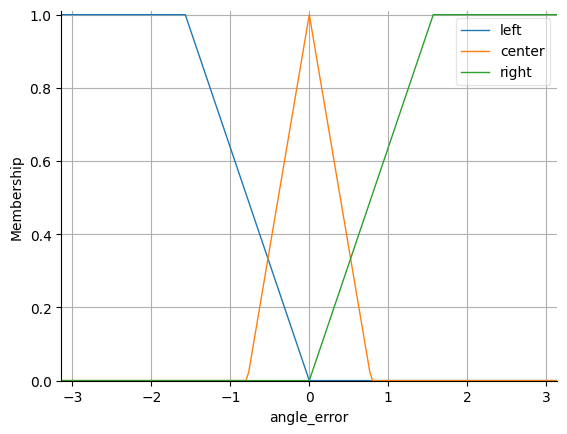

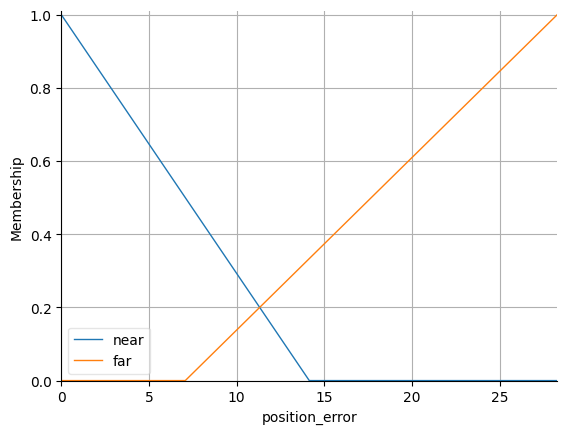

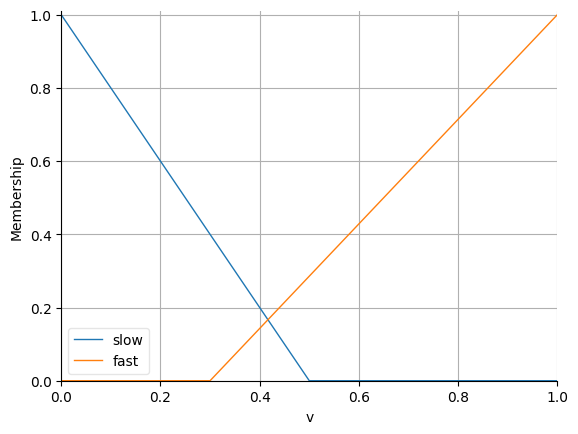

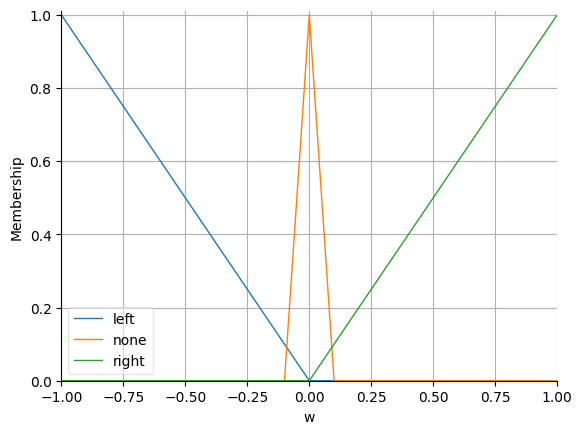

In [ ]:
angle_error.view()
plt.grid()
position_error.view()
plt.grid()
linear_speed.view()
plt.grid()
angular_speed.view()
plt.grid()

### Reglas difusas

In [ ]:
rules = [
    ctrl.Rule(angle_error['center'] & position_error['far'], (linear_speed['fast'], angular_speed['none'])),
    ctrl.Rule(angle_error['left'], (linear_speed['slow'], angular_speed['left'])),
    ctrl.Rule(angle_error['right'], (linear_speed['slow'], angular_speed['right'])),
    ctrl.Rule(position_error['near'], (linear_speed['slow'], angular_speed['none'])),
]

### Fuzzificación, Agregación y Deffuzificación

In [ ]:
fuzzy_ctrl = ctrl.ControlSystem(rules) # Fuzzificación
fuzzy_sim = ctrl.ControlSystemSimulation(fuzzy_ctrl) # Agregación y Deffuzificación
def fuzzy_controller(angle_err, pos_err):
    fuzzy_sim.input['angle_error'] = angle_err
    fuzzy_sim.input['position_error'] = pos_err
    fuzzy_sim.compute()
    linear_speed_control = fuzzy_sim.output['v']
    angular_speed_control = fuzzy_sim.output['w']
    return linear_speed_control, angular_speed_control

In [ ]:
clientID = connect(19999)
_, system = sim.simxGetObjectHandle(clientID,'./PioneerP3DX',sim.simx_opmode_blocking)
_, right_wheel = sim.simxGetObjectHandle(clientID,'./rightMotor',sim.simx_opmode_blocking)
_, left_wheel = sim.simxGetObjectHandle(clientID,'./leftMotor',sim.simx_opmode_blocking)
Tf = 10
Ts = 0.01 # Tiempo de muestreo
t = np.arange(0, Tf+Ts, Ts)
N = len(t)
x = np.zeros(N) # Posición en X del robot
y = np.zeros(N) # Posición en Y del robot
theta = np.zeros(N) # Ángulo de orientación del robot
e_pos = np.zeros(N) # Vector de error de posición
e_gui = np.zeros(N) # Vector de error de orientación
u_pos_control = np.zeros(N) # Señal de control de posición (v)
u_gui_control = np.zeros(N) # Señal de control de orientación (w)

conectado a 19999


In [ ]:
wheel_radius = 0.0975
distance_wheels = 0.331
x_ref = 5
y_ref = -1
theta_ref = 0
for k in range(N):
    _, [x_current, y_current, _] = sim.simxGetObjectPosition(clientID, system, -1, sim.simx_opmode_blocking)
    _, [_, _, theta_current] = sim.simxGetObjectOrientation(clientID, system, -1, sim.simx_opmode_blocking)
    x[k] = x_current # Posición en x actual
    y[k] = y_current # Posición en y actual
    theta[k] = theta_current # Ángulo de orientación actual
    e_pos[k] = np.sqrt((x_ref - x[k])**2 + (y_ref - y[k])**2) # Error de posición
    e_gui[k] = np.arctan2(y_ref - y[k], x_ref - x[k]) - theta[k] # Error de orientación
    e_gui[k] = np.arctan2(np.sin(e_gui[k]), np.cos(e_gui[k])) # Eror de orientación normalizado [-pi, pi]
    u_pos_control[k], u_gui_control[k] = fuzzy_controller(e_gui[k], e_pos[k])
    angular_speed_right = (u_pos_control[k] + (distance_wheels/2)*u_gui_control[k])/wheel_radius
    angular_speed_left = (u_pos_control[k] - (distance_wheels/2)*u_gui_control[k])/wheel_radius
    sim.simxSetJointTargetVelocity(clientID, right_wheel, angular_speed_right, sim.simx_opmode_oneshot)
    sim.simxSetJointTargetVelocity(clientID, left_wheel, angular_speed_left, sim.simx_opmode_oneshot)
    #time.sleep(Ts)

In [ ]:
df = pd.DataFrame({'t': t, 'y':y, 'x':x, 'e_pos':e_pos, 'e_gui':e_gui,
                   'u_pos':u_pos_control, 'u_gui':u_gui_control})
fig = px.line(df, x='t', y='y', title='', labels={'t': 'Time [s]', 'y': 'Y position [m]'})
fig.update_traces(line=dict(color='blue', width=4))
fig.show()
fig = px.line(df, x='t', y='x', title='', labels={'t': 'Time', 'x': 'X position [m]'})
fig.update_traces(line=dict(color='blue', width=4))
fig.show()
fig = px.line(df, x='t', y='e_pos', title='', labels={'t': 'Time', 'e_pos': 'Error position [m]'})
fig.update_traces(line=dict(color='red', width=4))
fig.show()
fig = px.line(df, x='t', y='u_pos', title='', labels={'t': 'Time', 'u_pos': 'Señal de control v [m/s] '})
fig.update_traces(line=dict(color='yellow', width=4))
fig.show()